In [30]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing

prefix = 'FTTBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')

# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(result)
# input_filename = 'input/test.csv'
output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

price_data = processing.import_binance_prices(path, result)
price_data2 = processing.de_freq(price_data, 180)
price_list = [None]*len(price_data2)
for i in range(len(price_data2)):
    price_list[i] = {'DOT': price_data2[i].price}
print(price_list[0:10])

['FTTBUSD-1s-2022-11-07.csv', 'FTTBUSD-1s-2022-11-08.csv', 'FTTBUSD-1s-2022-11-09.csv']
[{'DOT': 22.26}, {'DOT': 22.26}, {'DOT': 22.24}, {'DOT': 22.31}, {'DOT': 22.32}, {'DOT': 22.41}, {'DOT': 22.46}, {'DOT': 22.4}, {'DOT': 22.36}, {'DOT': 22.35}]


In [31]:
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_feeless_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'HDX': 0.05,
    'USD': 1,
    'LRNA': 0.5,
    'R1': 2,
    'R2': 2/3,
    'DOT': price_list[0]['DOT']
}

def lrna_price(asset: str):
    return price_dict['LRNA'] / price_dict[asset]

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 1000000, 'LRNA_price': lrna_price('USD')},
                'R1': {'liquidity': 1000000, 'LRNA_price': lrna_price('R1')},
                'R2': {'liquidity': 3000000, 'LRNA_price': lrna_price('R2')},
                'DOT': {'liquidity': 1000000, 'LRNA_price': lrna_price('DOT')}
            },
            lrna_fee=0.00,
            asset_fee=0.00
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000},
            trade_strategy=omnipool_feeless_arbitrage(
                pool_id='omnipool'
            )
        )
    },
    evolve_function=historical_prices(price_list),
    external_market=price_dict
)
print(len(price_list))
time_steps = len(price_list)-1
events = run.run(initial_state, time_steps=time_steps)

events = processing.postprocessing(events, optional_params=['withdraw_val'])

1439
Starting simulation...
Execution time: 12.886 seconds.


<AxesSubplot:title={'center':'asset price: R2    '}>

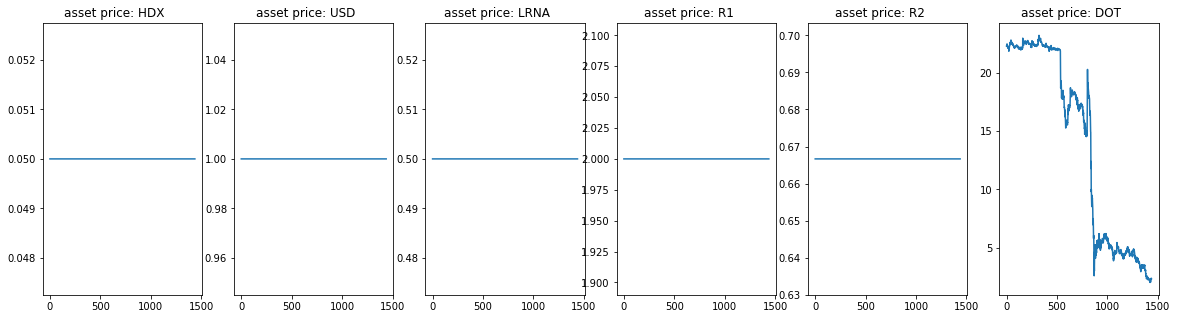

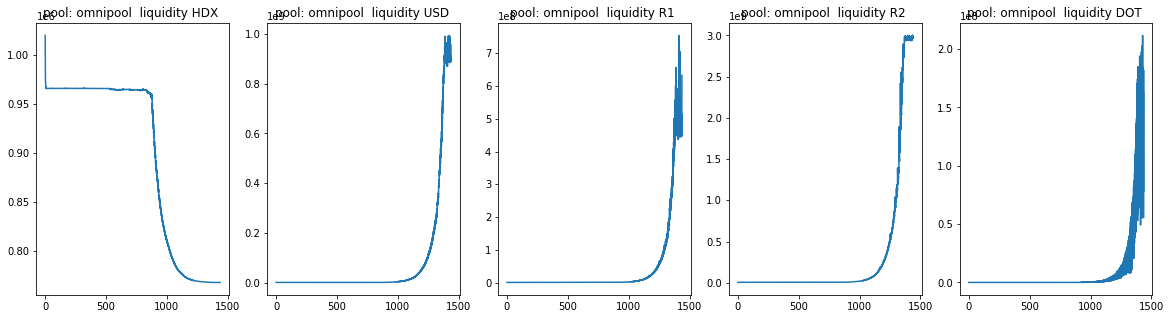

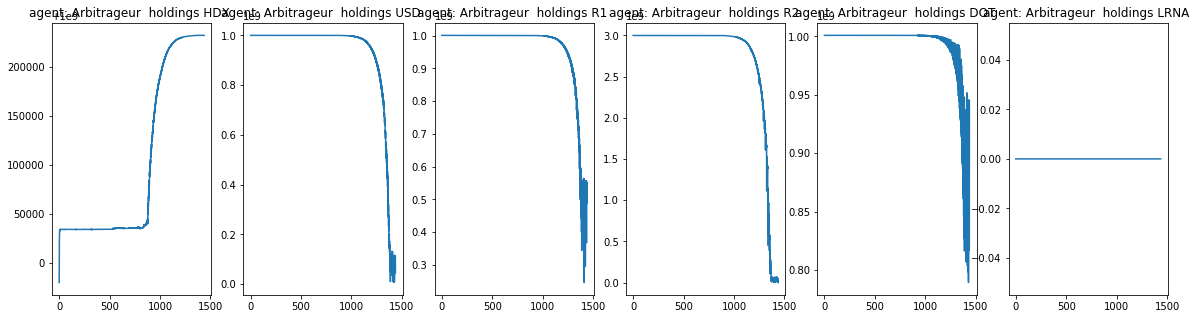

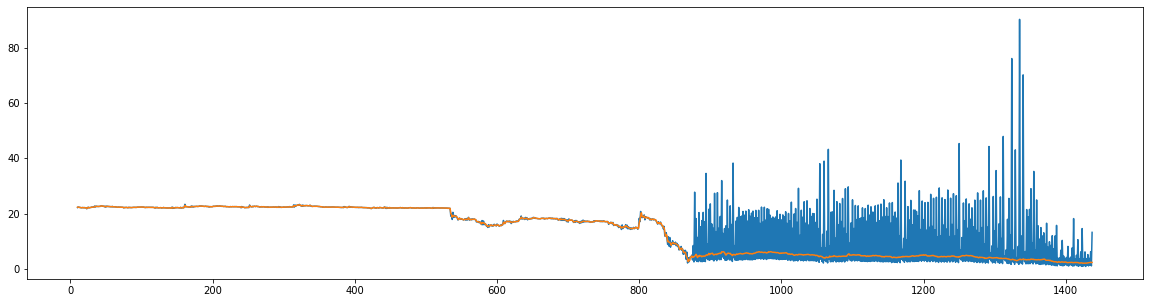

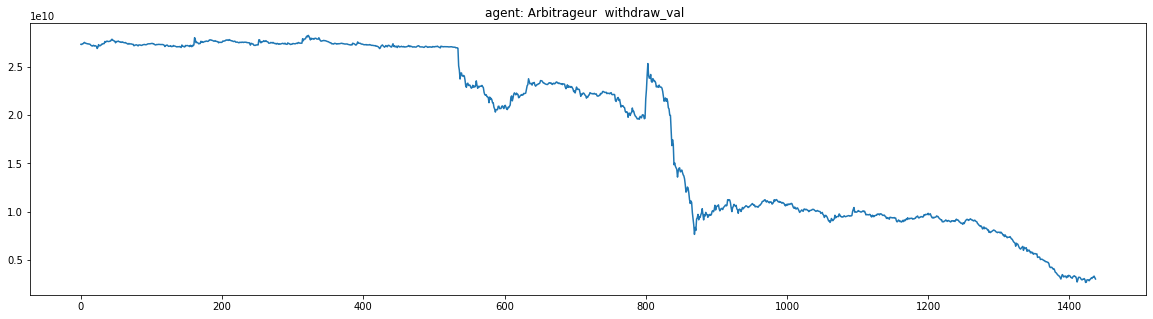

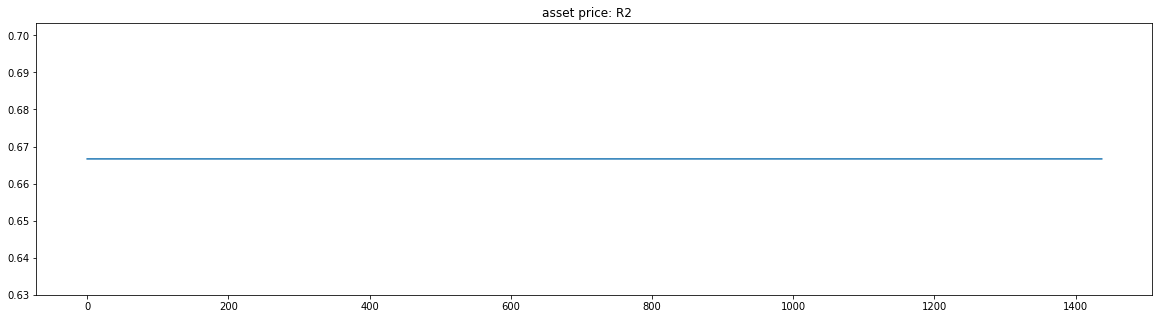

In [32]:
pu.plot(events, asset='all')
pu.plot(events, pool='omnipool', prop='liquidity')
lrna_price_in_usd = [event['state'].pools['omnipool'].liquidity['USD'] / event['state'].pools['omnipool'].lrna['USD'] for event in events]
DOT_pool_price_usd = [event['state'].pools['omnipool'].lrna['DOT'] * lrna_price_in_usd[i] / event['state'].pools['omnipool'].liquidity['DOT'] for i, event in enumerate(events)]
pu.plot(events, agent='Arbitrageur', prop='holdings')
plt.figure(figsize=(20, 5))
plt.plot(range(10,time_steps), DOT_pool_price_usd[10::])
# plt.plot(range(100), DOT_pool_price_usd[0:100])
plt.plot(range(10,time_steps), pu.get_datastream(events, asset='DOT')[10::])
# plt.plot(range(100), pu.get_datastream(events, asset='DOT')[0:100])
pu.plot(events, agent='Arbitrageur', prop='withdraw_val')
pu.plot(events, asset='R2')